#IE7300 18404 Statistical Learning for Engineers

# In-Vehicle Coupon Recommendation System

| Team Member                | NUID      |
|----------------------------|-----------|
| Achala Shenoy              | 002736738 |
| Ankita Shukla              | 002920460 |
| Navya Pragathi Molugaram   | 002774072 |
| Sanidhya Mathur            | 002766999 |


This project entails an in-depth exploration of a consumer behavior dataset, employing extensive Exploratory Data Analysis (EDA) and implementing various machine learning algorithms. The dataset encompasses 26 columns, including demographic information, preferences, and responses to promotional coupons. Through meticulous data cleaning, preprocessing, and feature engineering, the project aims to uncover patterns, optimize feature
selection, and develop predictive models.


The primary goal of this project is to develop a predictive model capable of discerning the likelihood of coupon redemption based on a myriad of contextual factors. By comprehensively exploring and preprocessing the dataset, applying robust machine learning algorithms, and fine-tuning model parameters, the intention is to create a tool that can assist marketers in optimizing coupon distribution strategies. The project seeks not only to predict consumer responses accurately but also to offer insights into the key features influencing these responses.

In [160]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import files

from tqdm import tqdm
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    mean_squared_error,
    precision_recall_fscore_support,
)
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier

import time

In [161]:
from google.colab import files
import pandas as pd

# Upload CSV file
uploaded = files.upload()

# Get the uploaded file name
file_name = list(uploaded.keys())[0]

# Reading the dataset
df_coupon = pd.read_csv(file_name)

# Display information about the DataFrame
df_coupon.info()

Saving in-vehicle-coupon-recommendation.csv to in-vehicle-coupon-recommendation (4).csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14

In [162]:
# Set Pandas display option to show all columns
pd.set_option('display.max_columns', None)

# Display the first few rows of the DataFrame df_coupon
df_coupon.head()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,has_children,education,occupation,income,car,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3,1,1,0,0,1,0


## Data cleaning

In [163]:
# Display the shape of the DataFrame df_coupon
df_coupon.shape

(12684, 26)

In [164]:
# Identify and remove duplicate rows, keeping the last occurrence
duplicate = df_coupon[df_coupon.duplicated(keep='last')]

duplicate.shape

(74, 26)

In [165]:
df = df_coupon.drop_duplicates()
print(df.shape)  # Display the shape of the DataFrame after removing duplicates

(12610, 26)


In [166]:
# Check for missing values in the DataFrame
df.isna().sum()

destination                 0
passanger                   0
weather                     0
temperature                 0
time                        0
coupon                      0
expiration                  0
gender                      0
age                         0
maritalStatus               0
has_children                0
education                   0
occupation                  0
income                      0
car                     12502
Bar                       107
CoffeeHouse               217
CarryAway                 150
RestaurantLessThan20      129
Restaurant20To50          189
toCoupon_GEQ5min            0
toCoupon_GEQ15min           0
toCoupon_GEQ25min           0
direction_same              0
direction_opp               0
Y                           0
dtype: int64

There are 99.14% missing values in car column. Hence it can be omitted

In [167]:
# Drop the 'car' column from the DataFrame
df = df.drop(['car'], axis=1)

In [168]:
# Separate the DataFrame into categorical and numerical values
df_cat = df.select_dtypes(include=['object']).columns.tolist()
print('Categorical columns are:', df_cat)

df_num = df.select_dtypes(exclude=['object']).columns.tolist()
print('Numerical columns are:', df_num)

Categorical columns are: ['destination', 'passanger', 'weather', 'time', 'coupon', 'expiration', 'gender', 'age', 'maritalStatus', 'education', 'occupation', 'income', 'Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50']
Numerical columns are: ['temperature', 'has_children', 'toCoupon_GEQ5min', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min', 'direction_same', 'direction_opp', 'Y']


In [169]:
# Display descriptive statistics for numerical columns in the DataFrame
df[df_num].describe()

,temperature,has_children,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
count,12610.000000,12610.000000,12610.0,12610.000000,12610.000000,12610.000000,12610.000000,12610.000000
mean,63.267248,0.414512,1.0,0.559794,0.116019,0.215543,0.784457,0.567565
std,19.153386,0.492657,0.0,0.496432,0.320260,0.411215,0.411215,0.495434
min,30.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,55.000000,0.000000,1.0,0.000000,0.000000,0.000000,1.000000,0.000000
50%,80.000000,0.000000,1.0,1.000000,0.000000,0.000000,1.000000,1.000000
75%,80.000000,1.000000,1.0,1.000000,0.000000,0.000000,1.000000,1.000000
max,80.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000


The direction_same column has a low mean value, while the direction_opp column has a high mean value but they have the same variance. This could be due to the scenarios where the coupon destination is in the opposite position of the driver's position, and hence the values have the same context.
The toCoupon_GEQ5min column only has 1 unique value.

In [170]:
# Drop the 'direction_opp' and 'toCoupon_GEQ5min' columns from the DataFrame
df = df.drop(['direction_opp', 'toCoupon_GEQ5min'], axis=1)

In [171]:
# Display the value counts for the 'temperature' column
print(df['temperature'].value_counts())

# Display the value counts for the target variable 'Y'
print(df['Y'].value_counts())

80    6475
55    3830
30    2305
Name: temperature, dtype: int64
1    7157
0    5453
Name: Y, dtype: int64


Temperature and Y can be changed to object data type as it has categorical values

In [172]:
# Display descriptive statistics for categorical columns in the DataFrame
df[df_cat].describe()

,destination,passanger,weather,time,coupon,expiration,gender,age,maritalStatus,education,occupation,income,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50
count,12610,12610,12610,12610,12610,12610,12610,12610,12610,12610,12610,12610,12503,12393,12460,12481,12421
unique,3,4,3,5,5,2,2,8,5,6,25,9,5,5,5,5,5
top,No Urgent Place,Alone,Sunny,6PM,Coffee House,1d,Female,21,Married partner,Some college - no degree,Unemployed,$25000 - $37499,never,less1,1~3,1~3,less1
freq,6266,7248,10011,3220,3989,7031,6469,2642,5068,4325,1861,2006,5178,3362,4645,5356,6041


In [173]:
# Display the value counts for the 'age' column
print(df['age'].value_counts())

# Display the value counts for the 'occupation' column
print(df['occupation'].value_counts())

21         2642
26         2548
31         2019
50plus     1781
36         1317
41         1089
46          670
below21     544
Name: age, dtype: int64
Unemployed                                   1861
Student                                      1575
Computer & Mathematical                      1390
Sales & Related                              1088
Education&Training&Library                    939
Management                                    821
Office & Administrative Support               638
Arts Design Entertainment Sports & Media      627
Business & Financial                          543
Retired                                       493
Food Preparation & Serving Related            298
Healthcare Practitioners & Technical          244
Healthcare Support                            242
Community & Social Services                   239
Legal                                         219
Transportation & Material Moving              218
Architecture & Engineering                    17

We can summarize the age and occupation columns to fewer classifications

In [174]:
# Mapping age categories based on specified criteria
age_list = []
for i in df['age']:
    if i == 'below21':
        age = '<21'
    elif i == '21' or i == '26':
        age = '21-30'
    elif i == '31' or i == '36':
        age = '31-40'
    elif i == '41' or i == '46':
        age = '41-50'
    else:
        age = '>50'
    age_list.append(age)
df['age'] = age_list

In [175]:
# Mapping occupation categories based on specified criteria
occupation_list = []
for i in df['occupation']:
    if i in ['Installation Maintenance & Repair', 'Transportation & Material Moving', 'Food Preparation & Serving Related', 'Building & Grounds Cleaning & Maintenance']:
        occupation = 'Crafts'
    elif i in ['Architecture & Engineering', 'Education&Training&Library', 'Healthcare Practitioners & Technical', 'Management', 'Arts Design Entertainment Sports & Media', 'Computer & Mathematical', 'Legal', 'Business & Financial']:
        occupation = 'Professionals'
    elif i == 'Retired':
        occupation = 'Retired'
    elif i in ['Sales & Related', 'Personal Care & Service', 'Protective Service']:
        occupation = 'Service and sales'
    elif i == 'Student':
        occupation = 'Student'
    elif i in ['Healthcare Support', 'Life Physical Social Science', 'Community & Social Services', 'Construction & Extraction']:
        occupation = 'Technicians'
    elif i == 'Unemployed':
        occupation = 'Unemployed'
    else:
        occupation = 'Others'
    occupation_list.append(occupation)
df['occupation'] = occupation_list

In [176]:
# Display the updated value counts for the 'age' column
print(df['age'].value_counts())

# Display the updated value counts for the 'occupation' column
print(df['occupation'].value_counts())

21-30    5190
31-40    3336
>50      1781
41-50    1759
<21       544
Name: age, dtype: int64
Professionals        4958
Unemployed           1861
Student              1575
Service and sales    1437
Technicians           804
Others                789
Crafts                693
Retired               493
Name: occupation, dtype: int64


In [177]:
# Label encoding for ordinal variables

df1 = df.replace({'expiration':{'2h': 0, '1d' : 1},
                    'gender':{'Male': 0, 'Female' : 1},
                    'age':{'<21': 0, '21-30': 1, '31-40': 2, '41-50': 3, '>50': 4},
                    'education':{'Some High School': 0, 'High School Graduate': 1, 'Some college - no degree': 2, 'Associates degree': 3, 'Bachelors degree': 4, 'Graduate degree (Masters or Doctorate)': 5},
                    'Bar':{'never': 0, 'less1': 1, '1~3': 2, '4~8': 3, 'gt8': 4},
                    'CoffeeHouse':{'never': 0, 'less1': 1, '1~3': 2, '4~8': 3, 'gt8': 4},
                    'CarryAway':{'never': 0, 'less1': 1, '1~3': 2, '4~8': 3, 'gt8': 4},
                    'RestaurantLessThan20':{'never': 0, 'less1': 1, '1~3': 2, '4~8': 3, 'gt8': 4},
                    'Restaurant20To50':{'never': 0, 'less1': 1, '1~3': 2, '4~8': 3, 'gt8': 4},
                    'temperature':{30: 0, 55: 1, 80: 2}})
df1.head()


,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,has_children,education,occupation,income,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,Y
0,No Urgent Place,Alone,Sunny,1,2PM,Restaurant(<20),1,1,1,Unmarried partner,1,2,Unemployed,$37500 - $49999,0.0,0.0,NaN,3.0,2.0,0,0,0,1
1,No Urgent Place,Friend(s),Sunny,2,10AM,Coffee House,0,1,1,Unmarried partner,1,2,Unemployed,$37500 - $49999,0.0,0.0,NaN,3.0,2.0,0,0,0,0
2,No Urgent Place,Friend(s),Sunny,2,10AM,Carry out & Take away,0,1,1,Unmarried partner,1,2,Unemployed,$37500 - $49999,0.0,0.0,NaN,3.0,2.0,1,0,0,1
3,No Urgent Place,Friend(s),Sunny,2,2PM,Coffee House,0,1,1,Unmarried partner,1,2,Unemployed,$37500 - $49999,0.0,0.0,NaN,3.0,2.0,1,0,0,0
4,No Urgent Place,Friend(s),Sunny,2,2PM,Coffee House,1,1,1,Unmarried partner,1,2,Unemployed,$37500 - $49999,0.0,0.0,NaN,3.0,2.0,1,0,0,0


In [178]:
# Display information about categorical columns in the DataFrame df1

df1_cat = df1.select_dtypes(include = ['object']).copy()
df1_cat.info()

# Display the columns of the categorical DataFrame df1_cat
print(df1_cat.columns)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12610 entries, 0 to 12683
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   destination    12610 non-null  object
 1   passanger      12610 non-null  object
 2   weather        12610 non-null  object
 3   time           12610 non-null  object
 4   coupon         12610 non-null  object
 5   maritalStatus  12610 non-null  object
 6   occupation     12610 non-null  object
 7   income         12610 non-null  object
dtypes: object(8)
memory usage: 886.6+ KB
Index(['destination', 'passanger', 'weather', 'time', 'coupon',
       'maritalStatus', 'occupation', 'income'],
      dtype='object')


In [179]:
# Drop specified columns from df1
df1 = df1.drop(['destination', 'passanger', 'weather', 'time', 'coupon', 'maritalStatus', 'occupation', 'income'], axis = 1)

In [180]:
# Label encoding for categorical variables

df1_cat = df1_cat.astype('category')
for i in df1_cat.columns :
  df1_cat[i] = df1_cat[i].cat.codes

# Concatenate df1 and df1_cat to create df2

df2 = pd.concat([df1, df1_cat], axis=1)
df2 = df2[['destination', 'passanger', 'weather', 'time', 'coupon', 'maritalStatus', 'occupation', 'income', 'temperature', 'expiration', 'gender', 'age', 'has_children',
            'education', 'Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min',
            'direction_same', 'Y']]

In [181]:
df2

,destination,passanger,weather,time,coupon,maritalStatus,occupation,income,temperature,expiration,gender,age,has_children,education,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,Y
0,1,0,2,2,4,3,7,3,1,1,1,1,1,2,0.0,0.0,NaN,3.0,2.0,0,0,0,1
1,1,1,2,0,2,3,7,3,2,0,1,1,1,2,0.0,0.0,NaN,3.0,2.0,0,0,0,0
2,1,1,2,0,1,3,7,3,2,0,1,1,1,2,0.0,0.0,NaN,3.0,2.0,1,0,0,1
3,1,1,2,2,2,3,7,3,2,0,1,1,1,2,0.0,0.0,NaN,3.0,2.0,1,0,0,0
4,1,1,2,2,2,3,7,3,2,1,1,1,1,2,0.0,0.0,NaN,3.0,2.0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12679,0,3,0,3,1,2,4,6,1,1,0,1,0,4,0.0,0.0,2.0,3.0,2.0,0,0,1,1
12680,2,0,0,4,1,2,4,6,1,1,0,1,0,4,0.0,0.0,2.0,3.0,2.0,0,0,0,1
12681,2,0,1,4,2,2,4,6,0,1,0,1,0,4,0.0,0.0,2.0,3.0,2.0,0,0,1,0
12682,2,0,1,4,0,2,4,6,0,1,0,1,0,4,0.0,0.0,2.0,3.0,2.0,1,1,0,0


In [182]:
# Check for missing values in df2
df2.isna().sum()

destination               0
passanger                 0
weather                   0
time                      0
coupon                    0
maritalStatus             0
occupation                0
income                    0
temperature               0
expiration                0
gender                    0
age                       0
has_children              0
education                 0
Bar                     107
CoffeeHouse             217
CarryAway               150
RestaurantLessThan20    129
Restaurant20To50        189
toCoupon_GEQ15min         0
toCoupon_GEQ25min         0
direction_same            0
Y                         0
dtype: int64

In [183]:
# Fill missing values in selected columns with the most frequent value

df2['Bar']=df2['Bar'].fillna(df2['Bar'].value_counts().index[0])
df2['CoffeeHouse']=df2['CoffeeHouse'].fillna(df2['CoffeeHouse'].value_counts().index[0])
df2['CarryAway']=df2['CarryAway'].fillna(df2['CarryAway'].value_counts().index[0])
df2['RestaurantLessThan20']=df2['RestaurantLessThan20'].fillna(df2['RestaurantLessThan20'].value_counts().index[0])
df2['Restaurant20To50']=df2['Restaurant20To50'].fillna(df2['Restaurant20To50'].value_counts().index[0])

In [184]:
# Check for missing values in df2 after filling
df2.isna().sum()

destination             0
passanger               0
weather                 0
time                    0
coupon                  0
maritalStatus           0
occupation              0
income                  0
temperature             0
expiration              0
gender                  0
age                     0
has_children            0
education               0
Bar                     0
CoffeeHouse             0
CarryAway               0
RestaurantLessThan20    0
Restaurant20To50        0
toCoupon_GEQ15min       0
toCoupon_GEQ25min       0
direction_same          0
Y                       0
dtype: int64

## Feature Analysis

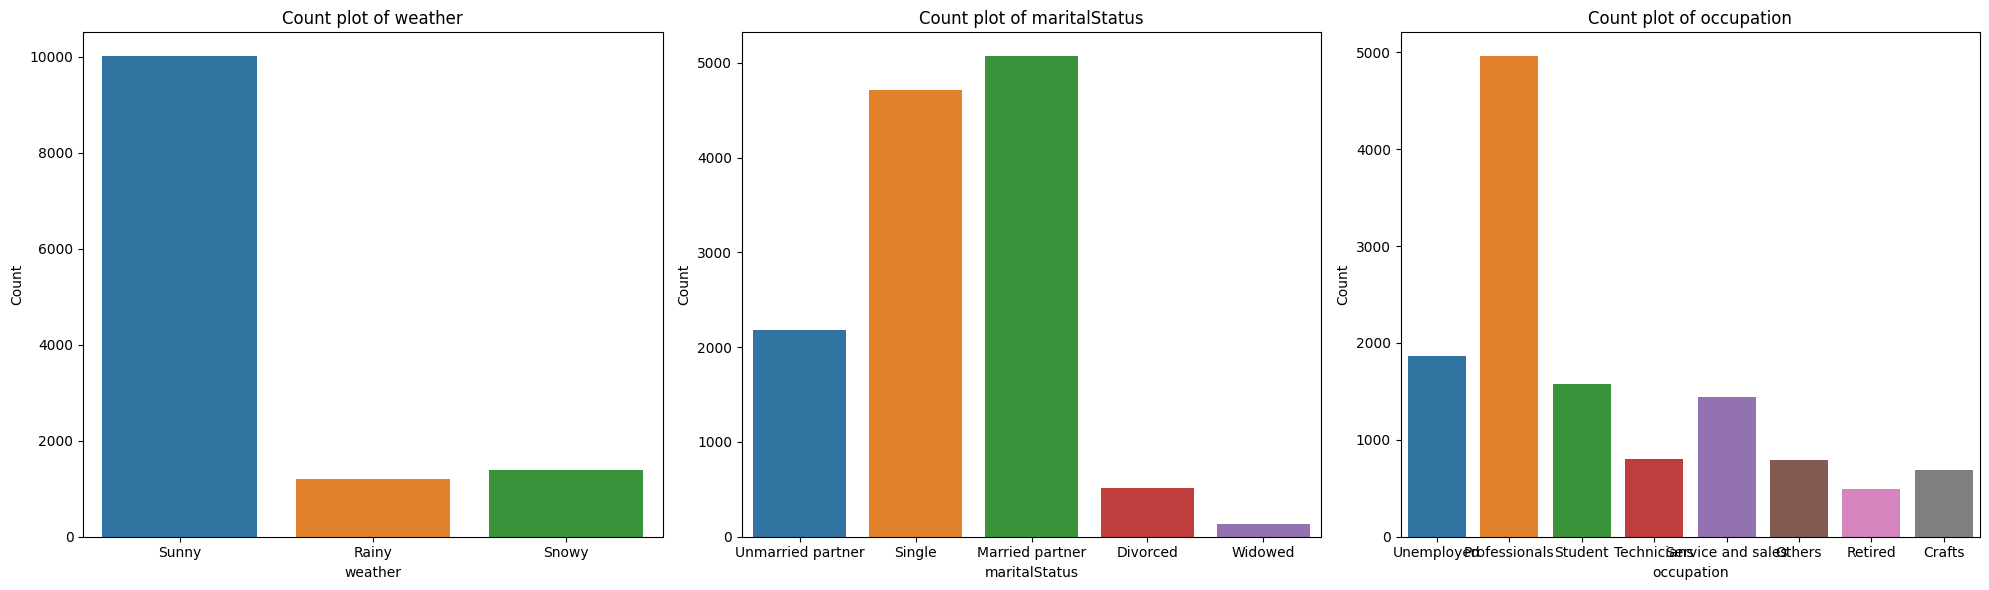

In [185]:
# Count plots for selected categorical columns
categorical_columns = ['weather', 'maritalStatus', 'occupation']

# Subplots for count plots
fig, axes = plt.subplots(nrows=1, ncols=len(categorical_columns), figsize=(20, 6))
for i, col in enumerate(categorical_columns):
    sns.countplot(x=col, data=df, ax=axes[i])
    axes[i].set_title(f'Count plot of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

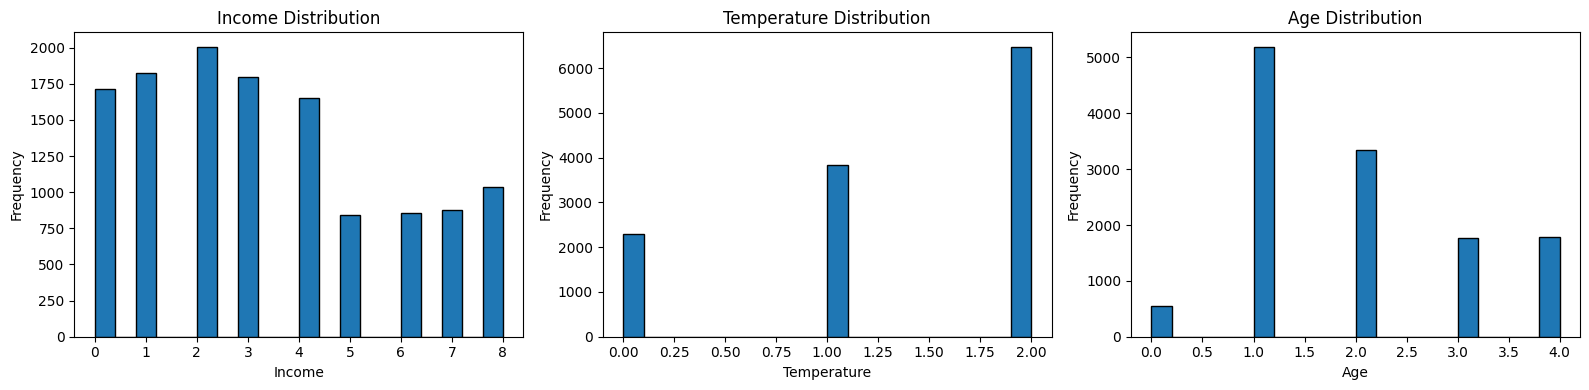

In [186]:
# Histograms for selected numerical columns
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))

# Income
axes[0].hist(df2['income'], bins=20, edgecolor='black')
axes[0].set_title('Income Distribution')
axes[0].set_xlabel('Income')
axes[0].set_ylabel('Frequency')

# Temperature
axes[1].hist(df2['temperature'], bins=20, edgecolor='black')
axes[1].set_title('Temperature Distribution')
axes[1].set_xlabel('Temperature')
axes[1].set_ylabel('Frequency')

# Age
axes[2].hist(df2['age'], bins=20, edgecolor='black')
axes[2].set_title('Age Distribution')
axes[2].set_xlabel('Age')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

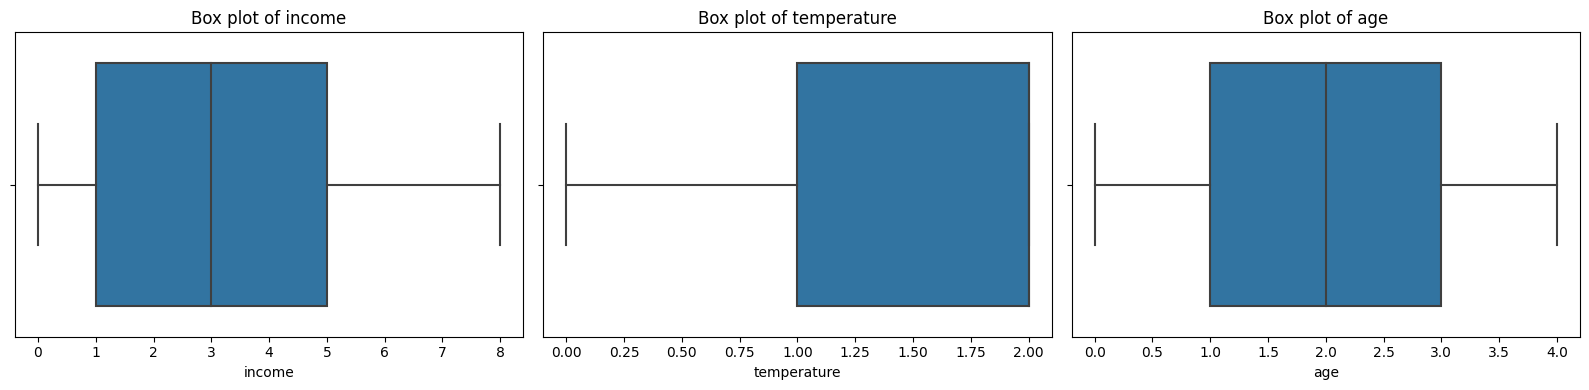

In [187]:
# Box plots for selected numerical columns

numerical_columns = ['income', 'temperature', 'age']
fig, axes = plt.subplots(nrows=1, ncols=len(numerical_columns), figsize=(16, 4))
for i, col in enumerate(numerical_columns):
    sns.boxplot(x=col, data=df2, ax=axes[i])
    axes[i].set_title(f'Box plot of {col}')
plt.tight_layout()
plt.show()

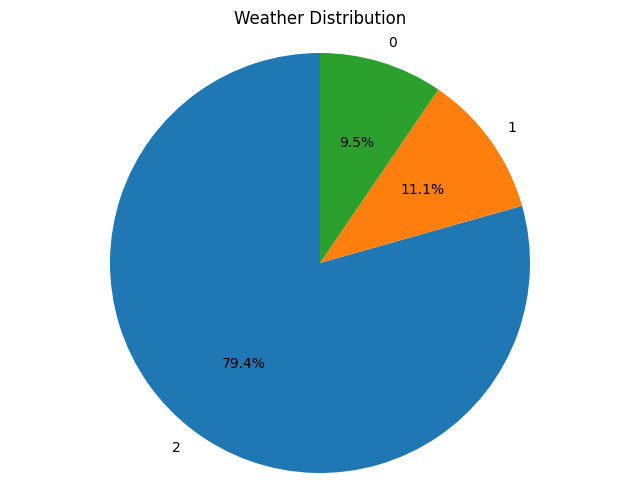

In [188]:
# Pie chart for Weather distribution

weather_counts = df2['weather'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(weather_counts, labels=weather_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Weather Distribution')
plt.axis('equal')
plt.show()

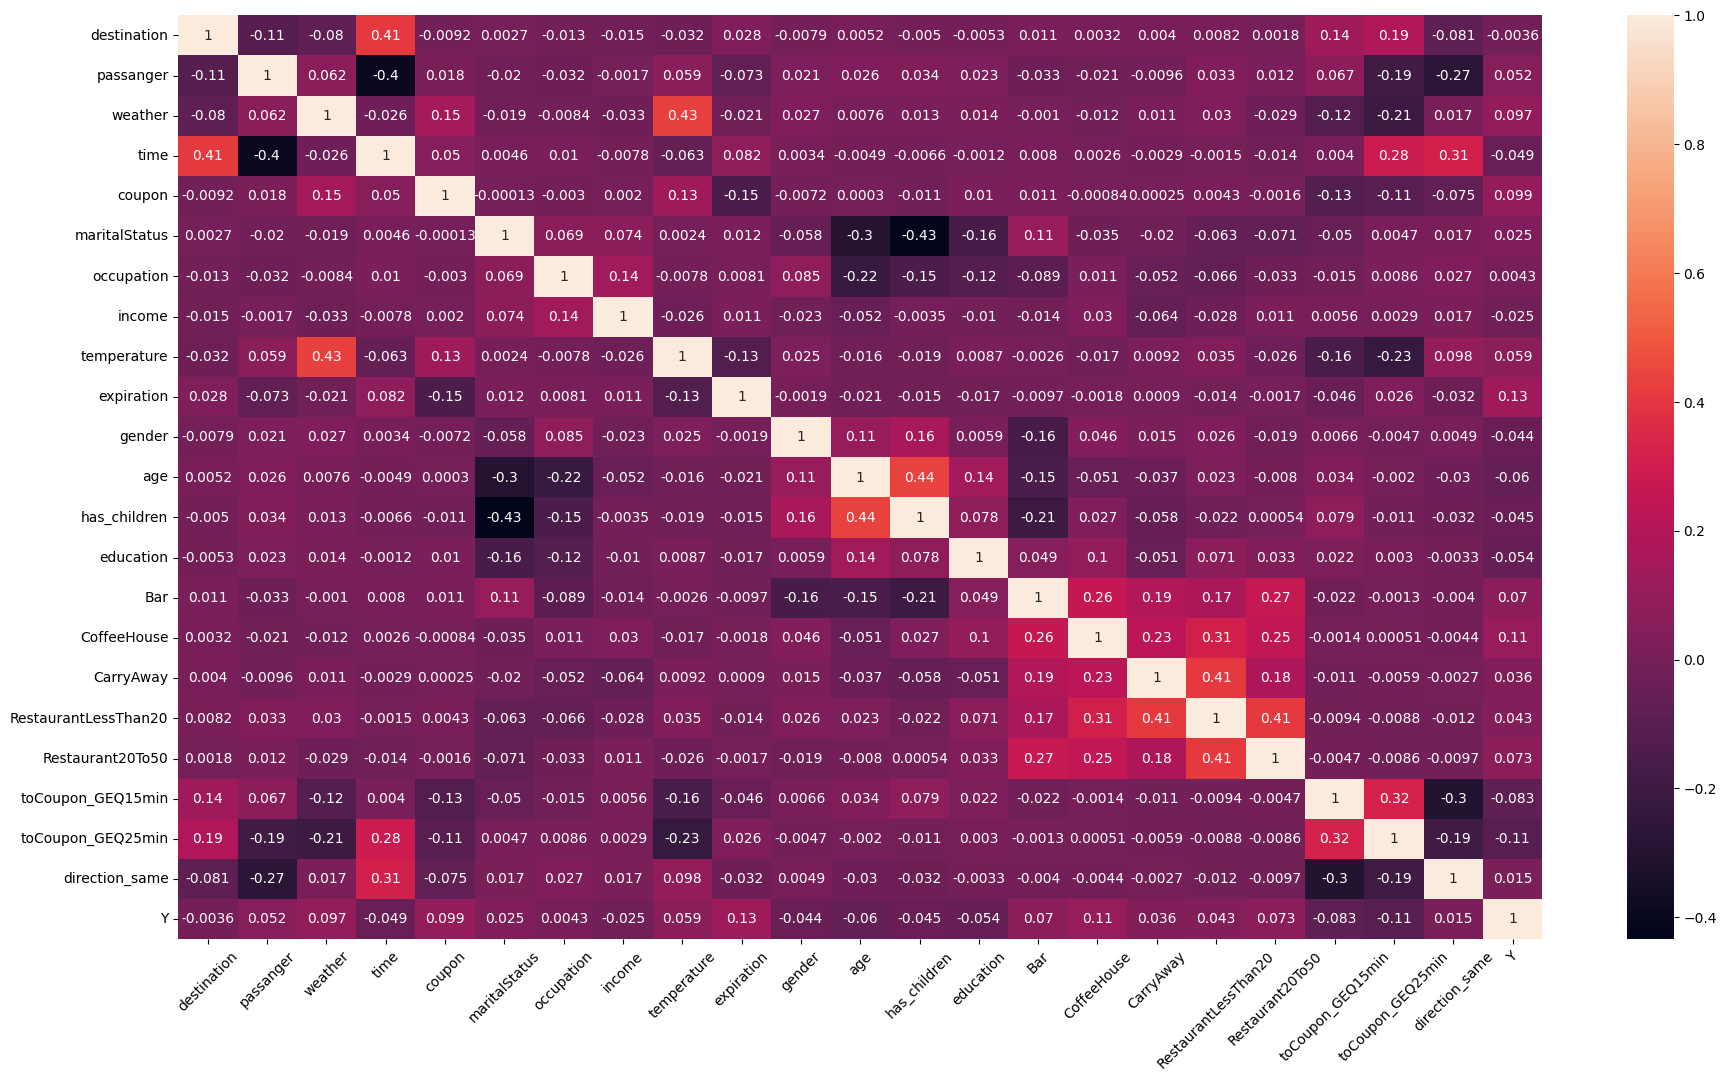

In [189]:
# Correlation plot for the entire DataFrame

plt.figure(figsize = (22,12))
sns.heatmap(df2.corr(), annot=True)
plt.xticks(rotation=45)
plt.show()

In [190]:
# Separating features (X) and target variable (y)

df2_X, y = df2.values[:, :-1], df2.values[:, -1]

## PCA

In [191]:
# Center the data by subtracting the mean
df2X_centered = df2_X - np.mean(df2_X, axis=0)

covariance_matrix = np.cov(df2X_centered.T)

# Eigen Decomposition
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

# Sort the eigenvalues and eigenvectors in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]

# Number of components
n_components = 14

# Top k eigenvectors corresponding to the largest eigenvalues
selected_eigenvectors = sorted_eigenvectors[:, :n_components]

# Transform the data using the selected eigenvectors
X_pca = np.dot(df2X_centered, selected_eigenvectors)

explained_variance_ratio = sorted_eigenvalues[:n_components] / np.sum(sorted_eigenvalues)

In [192]:
sum(explained_variance_ratio)

0.9366396827256371

In [193]:
X_pca.shape

(12610, 14)

In [194]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12610 entries, 0 to 12683
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   destination           12610 non-null  int8   
 1   passanger             12610 non-null  int8   
 2   weather               12610 non-null  int8   
 3   time                  12610 non-null  int8   
 4   coupon                12610 non-null  int8   
 5   maritalStatus         12610 non-null  int8   
 6   occupation            12610 non-null  int8   
 7   income                12610 non-null  int8   
 8   temperature           12610 non-null  int64  
 9   expiration            12610 non-null  int64  
 10  gender                12610 non-null  int64  
 11  age                   12610 non-null  int64  
 12  has_children          12610 non-null  int64  
 13  education             12610 non-null  int64  
 14  Bar                   12610 non-null  float64
 15  CoffeeHouse        

# Logistic Regression

In [195]:
class LogisticRegression:
    def __init__(self, X, y, epsilon, learning_rate, max_iterations):
        self.X = X
        self.y = y
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations
        self.epsilon = epsilon

    def split_data(self):
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.3, random_state=42)
        return X_train, X_test, y_train, y_test

    def add_x0(self, X):
        return np.column_stack([np.ones([X.shape[0],1]), X])

    def sigmoid(self, z):
        sig = 1 / (1 + np.exp(-z))
        return sig

    def cost_function(self, X, y):
        sig = self.sigmoid(X.dot(self.w))
        pred_ = y * np.log(sig) + (1 - y) * np.log(1 - sig)
        cost = pred_.sum()
        return cost

    def cost_derivative(self, X, y):
        sig = self.sigmoid(X.dot(self.w))
        grad = (sig - y).dot(X)
        return grad

    def gradient_descent(self, X, y):
        errors = []
        prev_error = float('inf')
        for i in tqdm(range(self.max_iterations), disable=True):
            self.w -= self.learning_rate * self.cost_derivative(X, y)
            error = self.cost_function(X, y)
            errors.append(error)
            if abs(prev_error - error) < self.epsilon:
                print('Model reached convergence')
                break
            prev_error = error

    def predict(self, X):
        sig = self.sigmoid(X.dot(self.w))
        return np.around(sig)

    def evaluate(self, y, y_hat):
        y = (y == 1)
        y_hat = (y_hat == 1)

        accuracy = (y == y_hat).sum() / y.size
        precision = (y & y_hat).sum() / y_hat.sum()
        recall = (y & y_hat).sum() / y.sum()
        f_score = 2 * (precision * recall) / (precision + recall)
        return accuracy, precision, recall, f_score

    def fit(self):
        X_train, X_test, y_train, y_test = self.split_data()

        self.w = np.ones(X_train.shape[1], dtype=np.float64) * 0

        # Measure the start time
        start_time = time.time()

        self.gradient_descent(X_train, y_train)

        # Measure the end time
        end_time = time.time()

        # Calculate and print the elapsed time
        elapsed_time = end_time - start_time
        print(f"Time taken for gradient descent: {elapsed_time:.4f} seconds")

    def bias_variance_tradeoff_plot(self, num_iterations=10, test_size=0.3):
        bias_squared = []
        variance = []

        self.fit()  # Fit the model once outside the loop

        for _ in range(num_iterations):
            X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=test_size)

            y_train_pred = self.predict(X_train)
            y_test_pred = self.predict(X_test)

            bias_squared.append(mean_squared_error(y_train, y_train_pred))
            variance.append(mean_squared_error(y_test, y_test_pred))

        # Plotting the bias-variance tradeoff without displaying metrics
        plt.plot(range(1, num_iterations + 1), bias_squared, label='Bias Squared')
        plt.plot(range(1, num_iterations + 1), variance, label='Variance')
        plt.xlabel('Iteration')
        plt.ylabel('Error')
        plt.title('Bias-Variance Tradeoff for Logistic Regression')
        plt.legend()
        plt.show()

In [196]:
# Assigning PCA-transformed features (X_pca) and target variable (y) to X and y
X = X_pca
y = y

Model reached convergence
Time taken for gradient descent: 1.9511 seconds
Accuracy:  0.5947660586835845
Recall:  0.6555323590814196
Precision:  0.5899483325504932
F1 Score:  0.6210135970333746
Model reached convergence
Time taken for gradient descent: 2.1733 seconds


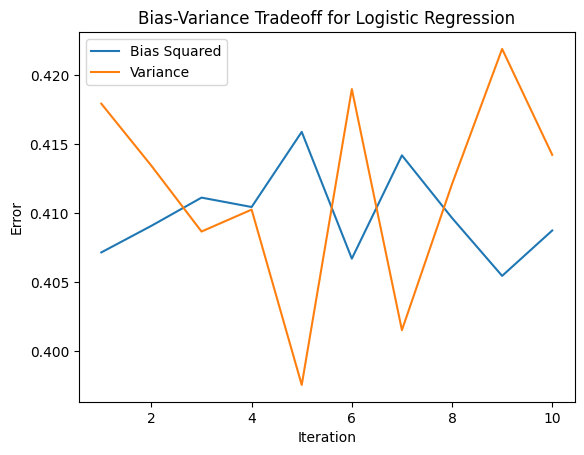

In [197]:
# Creating an instance of the LogisticRegression class with specified parameters
lr = LogisticRegression(X, y, epsilon=0.005, learning_rate=0.000001, max_iterations=3500)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = lr.split_data()

# Fitting the logistic regression model to the training data
lr.fit()

# Making predictions on the testing data
y_hat_test = lr.predict(X_test)

# Evaluating the performance of the logistic regression model on the testing data
accuracy_test, recall_test, precision_test, f_score_test = lr.evaluate(y_test, y_hat_test)

# Printing the evaluation metrics for the testing data
print('Accuracy: ', accuracy_test)
print('Recall: ', recall_test)
print('Precision: ', precision_test)
print('F1 Score: ', f_score_test)

# Storing the evaluation metrics in a list for further analysis or comparison
lr_metrics = [accuracy_test, recall_test, precision_test, f_score_test]

# Plotting the bias-variance tradeoff for the logistic regression model
lr.bias_variance_tradeoff_plot()

# Naive Bayes

In [198]:
class NaiveBayes:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.class_probs = {}
        self.class_means = {}
        self.class_stds = {}

    def split_data(self):
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.3, random_state=0)
        return X_train, X_test, y_train, y_test

    def calculate_class_probs(self, y):
        unique_classes, counts = np.unique(y, return_counts=True)
        class_probs = dict(zip(unique_classes, counts / len(y)))
        return class_probs

    def calculate_class_stats(self, X, y):
        class_means = {}
        class_stds = {}

        for class_val in np.unique(y):
            X_class = X[y == class_val]
            class_means[class_val] = np.mean(X_class, axis=0)
            class_stds[class_val] = np.std(X_class, axis=0)

        return class_means, class_stds

    def gaussian_pdf(self, x, mean, std):
        exponent = np.exp(-((x - mean) ** 2) / (2 * std ** 2))
        return (1 / (np.sqrt(2 * np.pi) * std)) * exponent

    def fit(self):
        X_train, X_test, y_train, y_test = self.split_data()

        # Measure the start time
        start_time = time.time()

        self.class_probs = self.calculate_class_probs(y_train)
        self.class_means, self.class_stds = self.calculate_class_stats(X_train, y_train)

        # Measure the end time
        end_time = time.time()

        # Calculate and print the elapsed time
        elapsed_time = end_time - start_time
        #print(f"Time taken for fitting: {elapsed_time:.4f} seconds")


    def predict(self, X):
        predictions = []

        for sample in X:
            probs = {}

            for class_val, class_prob in self.class_probs.items():
                likelihood = np.sum(np.log(self.gaussian_pdf(sample, self.class_means[class_val], self.class_stds[class_val])))
                probs[class_val] = np.log(class_prob) + likelihood

            predictions.append(max(probs, key=probs.get))

        return predictions

    def evaluate(self, y_true, y_pred):
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)

        return accuracy, precision, recall, f1

    def bias_variance_tradeoff_plot(self, X, y, num_iterations=10, test_size=0.3):
        bias_squared = []
        variance = []

        for _ in range(num_iterations):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

            # Measure the start time
            start_time = time.time()

            nb = NaiveBayes(X_train, y_train)
            nb.fit()

            y_train_pred = nb.predict(X_train)
            y_test_pred = nb.predict(X_test)

            bias_squared.append(mean_squared_error(y_train, y_train_pred))
            variance.append(mean_squared_error(y_test, y_test_pred))

        # Measure the end time
        end_time = time.time()
        # Calculate and print the elapsed time
        elapsed_time = end_time - start_time
        print(f"Time taken for prediction: {elapsed_time:.4f} seconds")

        average_bias_squared = np.mean(bias_squared)
        average_variance = np.mean(variance)

        plt.plot(range(1, num_iterations + 1), bias_squared, label='Bias Squared')
        plt.plot(range(1, num_iterations + 1), variance, label='Variance')
        plt.xlabel('Iteration')
        plt.ylabel('Error')
        plt.title('Bias-Variance Tradeoff for Naive Bayes')
        plt.legend()
        plt.show()

In [199]:
# Create an instance of the NaiveBayes class
nb = NaiveBayes(X, y)

Accuracy: 0.6026962727993656, Precision: 0.6251374129717845, Recall: 0.7804208600182982, F1 Score: 0.6942014242115971
Time taken for prediction: 0.5020 seconds


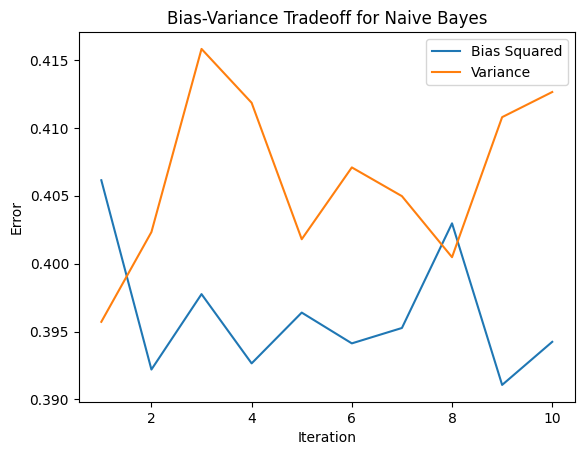

In [200]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = nb.split_data()

# Fit the Naive Bayes model
nb.fit()
# Make predictions on the test set
y_pred = nb.predict(X_test)

# Evaluate the performance of the model using various metrics
accuracy, precision, recall, f1 = nb.evaluate(y_test, y_pred)
print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}')

# Store metrics in nb_metrics
nb_metrics = [accuracy, precision, recall, f1]

#nb = NaiveBayes(X, y)
nb.bias_variance_tradeoff_plot(X, y, num_iterations=10)

# Neural Neworks

In [201]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        self.weights_input_hidden = np.random.randn(input_size, hidden_size)
        self.bias_input_hidden = np.zeros((1, hidden_size))
        self.weights_hidden_output = np.random.randn(hidden_size, output_size)
        self.bias_hidden_output = np.zeros((1, output_size))
        self.training_errors = []
        self.testing_errors = []

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def forward(self, X):
        self.hidden_input = np.dot(X, self.weights_input_hidden) + self.bias_input_hidden
        self.hidden_output = self.sigmoid(self.hidden_input)
        self.final_input = np.dot(self.hidden_output, self.weights_hidden_output) + self.bias_hidden_output
        self.final_output = self.sigmoid(self.final_input)
        return self.final_output

    def backward(self, X, y, learning_rate):
        error = y - self.final_output
        d_output = error * self.sigmoid_derivative(self.final_output)

        error_hidden_layer = d_output.dot(self.weights_hidden_output.T)
        d_hidden_layer = error_hidden_layer * self.sigmoid_derivative(self.hidden_output)

        self.weights_hidden_output += self.hidden_output.T.dot(d_output) * learning_rate
        self.bias_hidden_output += np.sum(d_output, axis=0, keepdims=True) * learning_rate
        self.weights_input_hidden += X.T.dot(d_hidden_layer) * learning_rate
        self.bias_input_hidden += np.sum(d_hidden_layer, axis=0, keepdims=True) * learning_rate

    def train(self, X, y, epochs, learning_rate, X_test, y_test):
        # Measure the start time for training
        start_time = time.time()

        for epoch in range(epochs):
            output = self.forward(X)
            self.backward(X, y, learning_rate)

            train_error = mean_squared_error(y, output)
            self.training_errors.append(train_error)

            test_output = self.forward(X_test)
            test_error = mean_squared_error(y_test, test_output)
            self.testing_errors.append(test_error)

        # Measure the end time for training
        end_time = time.time()

        # Calculate and print the elapsed time for training
        elapsed_time = end_time - start_time
        print(f"Time taken for training: {elapsed_time:.4f} seconds")

    def evaluate(self, y_true, y_pred):
        accuracy = accuracy_score(y_true, np.round(y_pred))
        precision = precision_score(y_true, np.round(y_pred))
        recall = recall_score(y_true, np.round(y_pred))
        f1 = f1_score(y_true, np.round(y_pred))

        return accuracy, precision, recall, f1

    def plot_errors(self):
        plt.plot(self.training_errors, label='Training Error')
        plt.plot(self.testing_errors, label='Testing Error')
        plt.xlabel('Epochs')
        plt.ylabel('Mean Squared Error')
        plt.title('Bias-Variance Tradeoff')
        plt.legend()
        plt.show()

Time taken for training: 7.3249 seconds
Total time taken: 7.3256 seconds
Test Accuracy: 0.577848268569918
Precision: 0.577848268569918
Recall: 1.0
F1 Score: 0.7324509968168872


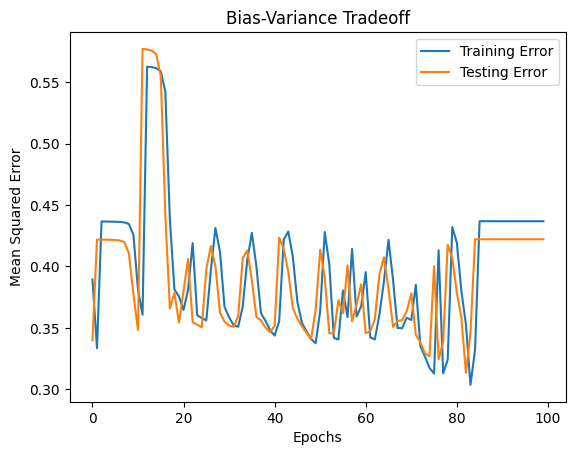

In [207]:
# Define neural network parameters

input_size = X_train.shape[1]
hidden_size = 64
output_size = 1
learning_rate = 0.01
epochs = 100

# Measure the start time for the entire process
start_time = time.time()

nn = NeuralNetwork(input_size, hidden_size, output_size)
nn.train(X_train, y_train.reshape(-1, 1), epochs=epochs, learning_rate=learning_rate, X_test=X_test, y_test=y_test)

# Measure the end time for the entire process
end_time = time.time()

# Calculate and print the total elapsed time
total_elapsed_time = end_time - start_time
print(f"Total time taken: {total_elapsed_time:.4f} seconds")

y_pred = nn.forward(X_test)

accuracy, precision, recall, f1 = nn.evaluate(y_test, y_pred)
print(f'Test Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

nn_metrics = [accuracy, precision, recall, f1]

nn.plot_errors()

# KNN classifier

In [208]:
class KNNClassifier:

    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.knn = None

    def split_data(self):
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.3, random_state=0)
        return X_train, X_test, y_train, y_test

    def fit(self, k=2):  # Set a default value for k
        # Measure the start time for fitting
        start_time = time.time()

        X_train, X_test, y_train, y_test = self.split_data()
        self.knn = KNeighborsClassifier(n_neighbors=k)  # Set the value of k
        self.knn.fit(X_train, y_train)

        # Measure the end time for fitting
        end_time = time.time()

        # Calculate and print the elapsed time for fitting
        elapsed_time = end_time - start_time
        print(f"Time taken for fitting: {elapsed_time:.4f} seconds")

    def predict(self, X):
        # Measure the start time for prediction
        start_time = time.time()

        predictions = self.knn.predict(X)

        # Measure the end time for prediction
        end_time = time.time()

        # Calculate and print the elapsed time for prediction
        elapsed_time = end_time - start_time
        print(f"Time taken for prediction: {elapsed_time:.4f} seconds")

        return predictions

    def evaluate(self, y_true, y_pred):
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')
        return accuracy, precision, recall, f1

    def bias_variance_tradeoff_plot(self, X, y, num_iterations=10, test_size=0.3):
        accuracy_scores_train = []
        accuracy_scores_test = []

        for _ in range(num_iterations):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

            knn = KNNClassifier(X_train, y_train)
            knn.fit()

            y_train_pred = knn.predict(X_train)
            y_test_pred = knn.predict(X_test)

            accuracy_train = accuracy_score(y_train, y_train_pred)
            accuracy_test = accuracy_score(y_test, y_test_pred)

            accuracy_scores_train.append(accuracy_train)
            accuracy_scores_test.append(accuracy_test)

        average_accuracy_train = np.mean(accuracy_scores_train)
        average_accuracy_test = np.mean(accuracy_scores_test)

        plt.plot(range(1, num_iterations + 1), accuracy_scores_train, label='Train Accuracy')
        plt.plot(range(1, num_iterations + 1), accuracy_scores_test, label='Test Accuracy')
        plt.xlabel('Iteration')
        plt.ylabel('Accuracy')
        plt.title('Bias-Variance Tradeoff for KNN')
        plt.legend()
        plt.show()

Time taken for fitting: 0.0470 seconds
Time taken for prediction: 1.0725 seconds
Time taken for fitting: 0.0202 seconds
Time taken for prediction: 1.1488 seconds
Time taken for prediction: 0.5720 seconds
Time taken for fitting: 0.0207 seconds
Time taken for prediction: 0.8764 seconds
Time taken for prediction: 0.3606 seconds
Time taken for fitting: 0.0111 seconds
Time taken for prediction: 0.8233 seconds
Time taken for prediction: 0.3562 seconds
Time taken for fitting: 0.0111 seconds
Time taken for prediction: 0.7839 seconds
Time taken for prediction: 0.3970 seconds
Time taken for fitting: 0.0111 seconds
Time taken for prediction: 0.7689 seconds
Time taken for prediction: 0.3803 seconds
Time taken for fitting: 0.0111 seconds
Time taken for prediction: 0.7466 seconds
Time taken for prediction: 0.3846 seconds
Time taken for fitting: 0.0112 seconds
Time taken for prediction: 0.7697 seconds
Time taken for prediction: 0.3851 seconds
Time taken for fitting: 0.0112 seconds
Time taken for pred

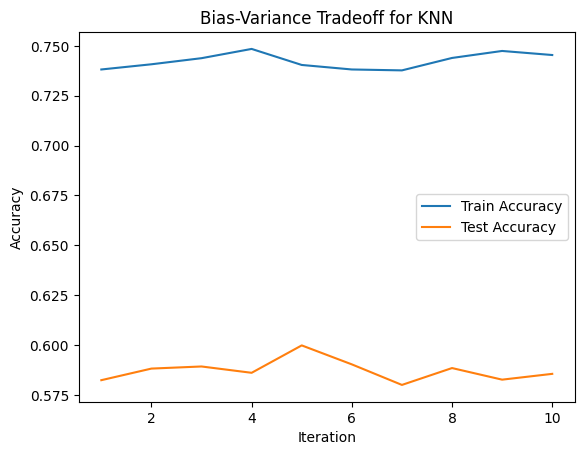

Total time taken: 14.2987 seconds
Mean Accuracy: 0.6330954269098599
Mean Precision: 0.6486928565885556
Mean Recall: 0.6330954269098599
Mean F1 Score: 0.6352235552052944


In [209]:
# Assuming X, y are defined somewhere before this point
knn_model = KNNClassifier(X, y)

# Measure the start time for the entire process
start_time = time.time()

knn_model.fit(k=6)  # Set the value of k to 6
knn_predictions = knn_model.predict(X_test)
accuracy, precision, recall, f1 = knn_model.evaluate(y_test, knn_predictions)
knn_model.bias_variance_tradeoff_plot(X, y)

# Measure the end time for the entire process
end_time = time.time()

# Calculate and print the total elapsed time
total_elapsed_time = end_time - start_time
print(f"Total time taken: {total_elapsed_time:.4f} seconds")

print(f"Mean Accuracy: {accuracy}")
print(f"Mean Precision: {precision}")
print(f"Mean Recall: {recall}")
print(f"Mean F1 Score: {f1}")

knn_metrics = [accuracy, precision, recall, f1]

## Conclusion

In [205]:
# Creating a DataFrame to store evaluation metrics for different models
metrics = pd.DataFrame([lr_metrics, nb_metrics, nn_metrics, knn_metrics],
                       columns=['accuracy', 'precision', 'recall', 'F1_score'])

# Naming the rows (index) of the DataFrame with the corresponding model names
metrics.index = ['Logistic Regression', 'Naive Bayes', 'Neural Network', 'KNN']

# Displaying the DataFrame containing evaluation metrics for each model
metrics

,accuracy,precision,recall,F1_score
Logistic Regression,0.594766,0.655532,0.589948,0.621014
Naive Bayes,0.602696,0.625137,0.780421,0.694201
Neural Network,0.578113,0.578001,1.000000,0.732574
KNN,0.633095,0.648693,0.633095,0.635224


Thus, **Neural Network** seems to be the most suitable model for the classification problem:

It has the highest F1 score, indicating a good balance between precision and recall.
Although there is overfitting, the alignment between training and testing errors suggests a well-balanced model.
The dataset may benefit from the non-linear capabilities of a neural network, capturing complex relationships.